# Random Forest

In [1]:
#!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,make_scorer,make_scorer, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from gensim.models.doc2vec import TaggedDocument
import os
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
reviews_df = pd.read_csv("reviews_preproc.csv")
reviews_df = reviews_df[["Texto Preprocesado","Valoración"]]
reviews_df = reviews_df.rename(columns={"Texto Preprocesado": "Texto"})
#reviews_df = reviews_df.sample(n = 50000) #Muestra!
reviews_df

,Texto,Valoración
0,excel menu del qualiti ingredi home cook good ...,5
1,realli enjoy food atmospher realli appreci pab...,5
2,amaz tapa skirt sierra nevada,5
3,way alberta make ideal stopov food fine order ...,3
4,staff littl desir work especi guy monday noon ...,1
...,...,...
383367,went review restaur seem good choic correct st...,2
383368,one return place happi spectacular delici,5
383369,excel lunch menu homemad qualiti food kind ser...,5
383370,good music good atmospher good view comfort,5


In [4]:
#Asignamos la polaridad en función de la valoración númerica
reviews_df['Polaridad'] = reviews_df['Valoración'].apply(lambda c: 'Positivo' if c > 3  else('Negativo' if c < 3 else 'Neutro'))
reviews_df

,Texto,Valoración,Polaridad
0,excel menu del qualiti ingredi home cook good ...,5,Positivo
1,realli enjoy food atmospher realli appreci pab...,5,Positivo
2,amaz tapa skirt sierra nevada,5,Positivo
3,way alberta make ideal stopov food fine order ...,3,Neutro
4,staff littl desir work especi guy monday noon ...,1,Negativo
...,...,...,...
383367,went review restaur seem good choic correct st...,2,Negativo
383368,one return place happi spectacular delici,5,Positivo
383369,excel lunch menu homemad qualiti food kind ser...,5,Positivo
383370,good music good atmospher good view comfort,5,Positivo


In [5]:
#Tomamos la polaridad negativa y positiva
reviews_df = reviews_df[(reviews_df['Polaridad'] =='Positivo') | 
          (reviews_df['Polaridad'] == 'Negativo')] 

In [6]:
#Tomamos la muestra para nuestra experimentación (50000)
reviews_positivo_df = reviews_df[reviews_df['Polaridad'] == "Positivo"]
reviews_positivo_df = reviews_positivo_df.dropna()
reviews_positivo_df = reviews_positivo_df.sample(n = 25000)

reviews_negativo_df = reviews_df[reviews_df['Polaridad'] == "Negativo"]
reviews_negativo_df = reviews_negativo_df.dropna()
reviews_negativo_df = reviews_negativo_df.sample(n = 25000)

reviews_df = pd.concat([reviews_positivo_df,reviews_negativo_df])
reviews_df

,Texto,Valoración,Polaridad
101750,went first time today left delight order 3 dif...,5,Positivo
306273,good pretti cheap polygon bar full truck drive...,5,Positivo
164262,good place someth breakfast tapa also burger v...,5,Positivo
102681,first congratul lui come back absolut big fan ...,5,Positivo
127665,look lost place where b abl enjoy special gast...,5,Positivo
...,...,...,...
220535,came quick bite close even though googl list open,1,Negativo
322561,extrem high price low qualiti,1,Negativo
114568,good diner two star vegetarian option,2,Negativo
16884,typic hunter bar anim head hang wall unpleas,1,Negativo


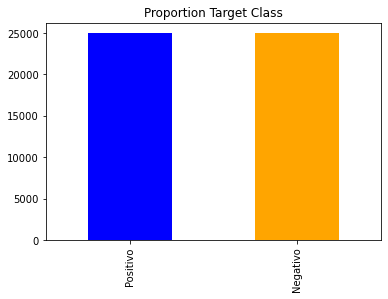

In [7]:
count_class=pd.value_counts(reviews_df["Polaridad"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [8]:
print('Positivo', round(reviews_df['Polaridad'].value_counts()['Positivo']/len(reviews_df) * 100), '%')
print('Negativo', round(reviews_df['Polaridad'].value_counts()['Negativo']/len(reviews_df) * 100), '%')

Positivo 50 %
Negativo 50 %


In [9]:
#Trabajamos con datos numericos (1=Positivo, 0=Negativo)
reviews_df['Texto'] = reviews_df['Texto'].astype(str)
reviews_df['Polaridad'] = reviews_df['Polaridad'].replace(['Positivo', 'Negativo'], [1, 0]) #!!!!!!
reviews_df

,Texto,Valoración,Polaridad
101750,went first time today left delight order 3 dif...,5,1
306273,good pretti cheap polygon bar full truck drive...,5,1
164262,good place someth breakfast tapa also burger v...,5,1
102681,first congratul lui come back absolut big fan ...,5,1
127665,look lost place where b abl enjoy special gast...,5,1
...,...,...,...
220535,came quick bite close even though googl list open,1,0
322561,extrem high price low qualiti,1,0
114568,good diner two star vegetarian option,2,0
16884,typic hunter bar anim head hang wall unpleas,1,0


In [10]:
main_text = reviews_df['Texto']
target = reviews_df['Polaridad']

print(len(main_text))
print(len(target))

50000
50000


In [12]:
#Etiquetamos cada comentario tokenizado con un ID único
def add_label(review):
    output = []
    for i, s in zip(review.index, review):
        output.append(TaggedDocument(s, ["review_" + str(i)]))
    return output

In [13]:
labeled_reviews = add_label(main_text)

In [14]:
#Vectorizamos con Doc2Vec para definir el modelo
from gensim.models import Doc2Vec

d2v_model = Doc2Vec(vector_size=200)
d2v_model.build_vocab([i for i in tqdm(labeled_reviews)])
d2v_model.train(labeled_reviews, total_examples=len(reviews_df['Texto']),epochs=10)
# Crea los vectores de tweets
docvec_arrays = np.zeros((len(reviews_df['Texto']), 200))
for i in range(len(reviews_df)):
    docvec_arrays[i,:] = d2v_model.docvecs[i].reshape((1,200))
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape
# Etiqueta todos los tweets
labeled_reviews = add_label(reviews_df['Texto'])

100%|██████████| 50000/50000 [00:00<00:00, 1921471.83it/s]
C:\Users\curri\AppData\Local\Temp/ipykernel_10932/1099985600.py:9: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  docvec_arrays[i,:] = d2v_model.docvecs[i].reshape((1,200))


In [15]:
docvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.052,0.050,0.031,0.033,0.050,-0.005,-0.002,-0.034,-0.046,0.020,...,-0.032,0.040,-0.000,0.007,0.095,-0.035,-0.035,-0.021,0.012,0.010
1,-0.063,0.032,0.036,-0.005,0.093,-0.005,-0.046,-0.017,-0.011,-0.005,...,0.035,0.047,-0.027,0.018,0.031,0.013,0.031,0.003,-0.003,0.020
2,-0.032,0.038,0.005,0.004,0.063,0.009,-0.007,-0.006,-0.011,0.011,...,0.005,0.045,-0.027,0.034,0.049,-0.031,-0.023,-0.003,0.020,0.008
3,0.014,0.052,0.057,-0.003,0.100,0.010,-0.053,-0.043,0.010,-0.039,...,0.003,0.005,-0.053,0.016,0.042,-0.013,-0.007,0.040,-0.008,0.009
4,-0.018,0.019,0.014,-0.039,0.075,-0.024,-0.003,0.059,0.001,-0.013,...,0.032,0.069,-0.021,-0.022,0.063,-0.002,0.008,0.002,0.012,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.027,0.035,0.013,0.012,0.061,-0.007,0.009,0.016,-0.023,0.012,...,0.012,0.049,-0.026,0.011,0.073,-0.022,-0.030,-0.017,0.024,0.012
49996,-0.008,0.005,-0.008,-0.016,0.072,0.005,-0.012,0.023,-0.012,-0.008,...,0.003,0.029,-0.019,0.007,0.033,-0.024,-0.033,0.004,0.027,0.008
49997,-0.034,0.035,0.022,0.023,0.023,0.010,-0.001,-0.042,-0.017,0.000,...,-0.004,0.019,-0.011,0.013,0.031,-0.038,-0.015,0.002,0.005,-0.004
49998,-0.006,0.046,-0.006,-0.004,0.087,0.004,-0.012,-0.027,0.020,0.004,...,0.002,0.043,-0.045,0.024,0.054,-0.019,-0.016,-0.003,0.035,0.030


In [16]:
#Definimos los conjuntos de datos de entrenamiento y prueba
X = docvec_df
y = target

X_train, X_test, y_train, y_test  = train_test_split(X,y,train_size=0.9,random_state=0)

In [18]:
#Definimos una matriz con los hiperparámetros a utilizar en la experimentación
grid = { 
    'n_estimators': [50,100,200],
    'max_features': ['auto', 'log2'],
    'criterion' :['gini', 'entropy']
}
# Define las metricas a obtener
scoring = {'accuracy': make_scorer(accuracy_score),
 'f1': make_scorer(f1_score, pos_label=1),
 'roc_auc': make_scorer(roc_auc_score)}

# Entrena los datos
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid,scoring=scoring,refit='accuracy', n_jobs=-1, cv=5, verbose=10)
rf_cv.fit(X_train, y_train)


# Predice los datos de test
y_pred = rf_cv.predict(X_test)

print('Best Accuracy Through Grid Search : {:.3f}'.format(rf_cv.best_score_))
print('Best Parameters : {}\n'.format(rf_cv.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Accuracy Through Grid Search : 0.898
Best Parameters : {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 200}



In [21]:
#Imprimimos métricas obtenidas
for accuracy, f1, roc_auc, params in zip(rf_cv.cv_results_['mean_test_accuracy'], 
                             rf_cv.cv_results_['mean_test_f1'], rf_cv.cv_results_['mean_test_roc_auc'], 
                             rf_cv.cv_results_['params']):
       print("%0.5f %0.5f %0.5f for %r" % (accuracy,f1,roc_auc, params))

0.89318 0.89212 0.89320 for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 50}
0.89576 0.89494 0.89577 for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
0.89676 0.89612 0.89677 for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 200}
0.89047 0.88909 0.89050 for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}
0.89396 0.89299 0.89398 for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
0.89540 0.89448 0.89542 for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 200}
0.89302 0.89230 0.89304 for {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 50}
0.89680 0.89648 0.89681 for {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}
0.89816 0.89800 0.89816 for {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 200}
0.89313 0.89234 0.89315 for {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 50}
0.89656 0.89604 0.89657 for {'criterion': 

In [22]:
#Se muestran los resultados en una matriz de Confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def ConfusionMatrix(y_pred, y_test):
     # Compute and plot the Confusion matrix
     cf_matrix = confusion_matrix(y_test, y_pred)
     categories = ['Negativo','Positivo']
     group_names = ['True Neg','False Pos', 'False Neg','True Pos']
     group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / 
    np.sum(cf_matrix)]
     labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
     labels = np.asarray(labels).reshape(2,2)
     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
     xticklabels = categories, yticklabels = categories)
     plt.xlabel("Predicted label", fontdict = {'size':14}, labelpad = 10)
     plt.ylabel("True label" , fontdict = {'size':14}, labelpad = 10)
     plt.title ("Matriz de confusion", fontdict = {'size':18}, pad = 20)

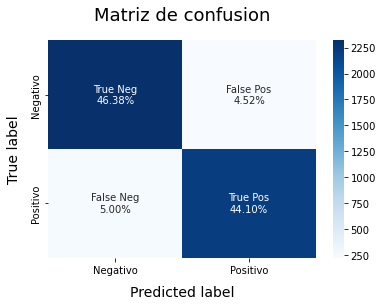

In [23]:
ConfusionMatrix(y_pred, y_test)